# ALS Detection with Action Recognition

### Import Libraries and Dependencies

In [1]:
import tensorflow
import cv2
import mediapipe as mp
from matplotlib import pyplot as plt
import sklearn
import os
import numpy as np

### Detect Face, Hand, and Pose Landmarks

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    # BGR -> RGB -> BGR
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Color Conversion
    image.flags.writeable = False # Image is no longer writeable
    results = model.process(image) # Make prediction
    image.flags.writeable = True # Image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # Color Conversion
    return image, results

In [4]:
def draw_styled_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                              mp_drawing.DrawingSpec(color=(80, 110, 10), thickness=1, circle_radius=1),
                              mp_drawing.DrawingSpec(color=(80, 256, 121),thickness=1, circle_radius=1)
                              ) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS, 
                              mp_drawing.DrawingSpec(color=(80, 22, 10), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(80, 44, 121),thickness=2, circle_radius=2)
                              ) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                              mp_drawing.DrawingSpec(color=(121, 22, 76), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(121, 44, 250),thickness=2, circle_radius=2)
                              ) # Draw lh connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                              mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(245, 66, 230),thickness=2, circle_radius=2)
                              ) # Draw rh connections

In [6]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        image, results = mediapipe_detection(frame, holistic)
        draw_styled_landmarks(image, results)
        cv2.imshow("OpenCV Camera", image)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [9]:
draw_styled_landmarks(frame, results)

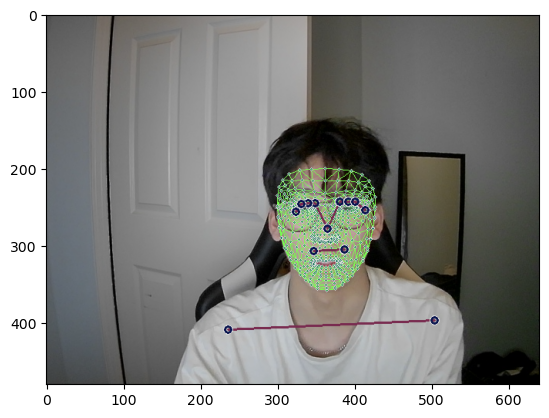

In [10]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

### Extract Keypoint Values

In [11]:
results.pose_landmarks

landmark {
  x: 0.570620596408844
  y: 0.5794392824172974
  z: -1.2515175342559814
  visibility: 0.9995898604393005
}
landmark {
  x: 0.5960534811019897
  y: 0.5076963901519775
  z: -1.198338270187378
  visibility: 0.998932421207428
}
landmark {
  x: 0.6128283739089966
  y: 0.506381630897522
  z: -1.1986249685287476
  visibility: 0.9992902874946594
}
landmark {
  x: 0.6273730397224426
  y: 0.5067350268363953
  z: -1.1988710165023804
  visibility: 0.9989538788795471
}
landmark {
  x: 0.5468254685401917
  y: 0.5112522840499878
  z: -1.2122732400894165
  visibility: 0.9990053176879883
}
landmark {
  x: 0.531287431716919
  y: 0.511884331703186
  z: -1.2116988897323608
  visibility: 0.9993178248405457
}
landmark {
  x: 0.5178412199020386
  y: 0.5137220025062561
  z: -1.212211012840271
  visibility: 0.9990687370300293
}
landmark {
  x: 0.6468809843063354
  y: 0.5294696688652039
  z: -0.7534464597702026
  visibility: 0.9990573525428772
}
landmark {
  x: 0.5074339509010315
  y: 0.5341641902923

In [12]:
def extract_keypoints(results):
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
    left_hand = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3) 
    right_hand = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, left_hand, right_hand])

In [13]:
result_test = extract_keypoints(results)

### Folder Setup

In [14]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['hello', 'thanks', 'iloveyou'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

### Collecting Keypoint Values for Training and Testing

In [15]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
#                 print(results)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [16]:
cap.release()
cv2.destroyAllWindows()

### Preprocess Data and Create Labels and Features

In [17]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [18]:
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

In [19]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [20]:
X = np.array(sequences)

In [21]:
y = to_categorical(labels).astype(int)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

### Build and Train LSTM Neural Network

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [24]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [25]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [26]:
res = [.7, 0.2, 0.1]
actions[np.argmax(res)]
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [29]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback]);

Epoch 1/2000
3/3 [==============================] - 0s 86ms/step - loss: 0.7858 - categorical_accuracy: 0.6118
Epoch 2/2000
3/3 [==============================] - 0s 89ms/step - loss: 0.7558 - categorical_accuracy: 0.6235
Epoch 3/2000
3/3 [==============================] - 0s 81ms/step - loss: 0.8594 - categorical_accuracy: 0.6118
Epoch 4/2000
3/3 [==============================] - 0s 89ms/step - loss: 0.8608 - categorical_accuracy: 0.6235
Epoch 5/2000
3/3 [==============================] - 0s 88ms/step - loss: 1.3058 - categorical_accuracy: 0.6118
Epoch 6/2000
3/3 [==============================] - 0s 88ms/step - loss: 1.2078 - categorical_accuracy: 0.3882
Epoch 7/2000
3/3 [==============================] - 0s 78ms/step - loss: 0.9782 - categorical_accuracy: 0.6118
Epoch 8/2000
3/3 [==============================] - 0s 79ms/step - loss: 1.0021 - categorical_accuracy: 0.4588
Epoch 9/2000
3/3 [==============================] - 0s 83ms/step - loss: 0.6908 - categorical_accuracy: 0.6235
E

3/3 [==============================] - 0s 94ms/step - loss: 0.5048 - categorical_accuracy: 0.7765
Epoch 75/2000
3/3 [==============================] - 0s 82ms/step - loss: 0.4746 - categorical_accuracy: 0.7882
Epoch 76/2000
3/3 [==============================] - 0s 80ms/step - loss: 0.6944 - categorical_accuracy: 0.7412
Epoch 77/2000
3/3 [==============================] - 0s 85ms/step - loss: 1.1557 - categorical_accuracy: 0.6353
Epoch 78/2000
3/3 [==============================] - 0s 109ms/step - loss: 1.1499 - categorical_accuracy: 0.5765
Epoch 79/2000
3/3 [==============================] - 0s 115ms/step - loss: 0.6532 - categorical_accuracy: 0.7176
Epoch 80/2000
3/3 [==============================] - 0s 147ms/step - loss: 0.6334 - categorical_accuracy: 0.6941
Epoch 81/2000
3/3 [==============================] - 0s 108ms/step - loss: 0.5366 - categorical_accuracy: 0.7529
Epoch 82/2000
3/3 [==============================] - 0s 121ms/step - loss: 0.5602 - categorical_accuracy: 0.7294
E

3/3 [==============================] - 0s 82ms/step - loss: 0.3579 - categorical_accuracy: 0.8706
Epoch 147/2000
3/3 [==============================] - 0s 80ms/step - loss: 0.5060 - categorical_accuracy: 0.7294
Epoch 148/2000
3/3 [==============================] - 0s 84ms/step - loss: 0.5809 - categorical_accuracy: 0.7176
Epoch 149/2000
3/3 [==============================] - 0s 90ms/step - loss: 0.6188 - categorical_accuracy: 0.7529
Epoch 150/2000
3/3 [==============================] - 0s 88ms/step - loss: 0.5131 - categorical_accuracy: 0.7294
Epoch 151/2000
3/3 [==============================] - 0s 81ms/step - loss: 0.4801 - categorical_accuracy: 0.7647
Epoch 152/2000
3/3 [==============================] - 0s 83ms/step - loss: 0.4283 - categorical_accuracy: 0.8353
Epoch 153/2000
3/3 [==============================] - 0s 79ms/step - loss: 0.3803 - categorical_accuracy: 0.8235
Epoch 154/2000
3/3 [==============================] - 0s 84ms/step - loss: 0.3947 - categorical_accuracy: 0.788

3/3 [==============================] - 1s 196ms/step - loss: 0.3653 - categorical_accuracy: 0.8471
Epoch 219/2000
3/3 [==============================] - 1s 186ms/step - loss: 0.4230 - categorical_accuracy: 0.8118
Epoch 220/2000
3/3 [==============================] - 0s 116ms/step - loss: 0.4835 - categorical_accuracy: 0.7765
Epoch 221/2000
3/3 [==============================] - 0s 98ms/step - loss: 0.4591 - categorical_accuracy: 0.7647
Epoch 222/2000
3/3 [==============================] - 0s 103ms/step - loss: 0.4138 - categorical_accuracy: 0.8235
Epoch 223/2000
3/3 [==============================] - 0s 99ms/step - loss: 0.4229 - categorical_accuracy: 0.7765
Epoch 224/2000
3/3 [==============================] - 0s 100ms/step - loss: 0.3846 - categorical_accuracy: 0.8235
Epoch 225/2000
3/3 [==============================] - 0s 110ms/step - loss: 0.4162 - categorical_accuracy: 0.8118
Epoch 226/2000
3/3 [==============================] - 0s 95ms/step - loss: 0.5203 - categorical_accuracy:

3/3 [==============================] - 0s 111ms/step - loss: 0.3970 - categorical_accuracy: 0.8353
Epoch 291/2000
3/3 [==============================] - 0s 117ms/step - loss: 0.3597 - categorical_accuracy: 0.7882
Epoch 292/2000
3/3 [==============================] - 0s 117ms/step - loss: 0.3411 - categorical_accuracy: 0.8235
Epoch 293/2000
3/3 [==============================] - 0s 118ms/step - loss: 0.4169 - categorical_accuracy: 0.7765
Epoch 294/2000
3/3 [==============================] - 0s 119ms/step - loss: 0.5102 - categorical_accuracy: 0.7412
Epoch 295/2000
3/3 [==============================] - 0s 161ms/step - loss: 0.4427 - categorical_accuracy: 0.7647
Epoch 296/2000
3/3 [==============================] - 0s 137ms/step - loss: 0.4415 - categorical_accuracy: 0.8000
Epoch 297/2000
3/3 [==============================] - 0s 130ms/step - loss: 0.4994 - categorical_accuracy: 0.7412
Epoch 298/2000
3/3 [==============================] - 0s 122ms/step - loss: 0.5932 - categorical_accura

3/3 [==============================] - 0s 102ms/step - loss: 0.4403 - categorical_accuracy: 0.7647
Epoch 363/2000
3/3 [==============================] - 0s 131ms/step - loss: 0.3874 - categorical_accuracy: 0.8118
Epoch 364/2000
3/3 [==============================] - 0s 106ms/step - loss: 0.2859 - categorical_accuracy: 0.8706
Epoch 365/2000
3/3 [==============================] - 0s 114ms/step - loss: 0.3183 - categorical_accuracy: 0.8235
Epoch 366/2000
3/3 [==============================] - 0s 122ms/step - loss: 0.3533 - categorical_accuracy: 0.8235
Epoch 367/2000
3/3 [==============================] - 0s 140ms/step - loss: 0.3466 - categorical_accuracy: 0.8235
Epoch 368/2000
3/3 [==============================] - 0s 124ms/step - loss: 0.3161 - categorical_accuracy: 0.8824
Epoch 369/2000
3/3 [==============================] - 0s 153ms/step - loss: 0.3187 - categorical_accuracy: 0.8353
Epoch 370/2000
3/3 [==============================] - 0s 116ms/step - loss: 0.2975 - categorical_accura

3/3 [==============================] - 0s 82ms/step - loss: 0.2744 - categorical_accuracy: 0.8706
Epoch 435/2000
3/3 [==============================] - 0s 86ms/step - loss: 0.2843 - categorical_accuracy: 0.9176
Epoch 436/2000
3/3 [==============================] - 0s 90ms/step - loss: 0.2792 - categorical_accuracy: 0.8471
Epoch 437/2000
3/3 [==============================] - 0s 95ms/step - loss: 0.2523 - categorical_accuracy: 0.8941
Epoch 438/2000
3/3 [==============================] - 0s 135ms/step - loss: 0.2647 - categorical_accuracy: 0.8941
Epoch 439/2000
3/3 [==============================] - 0s 84ms/step - loss: 0.3060 - categorical_accuracy: 0.8824
Epoch 440/2000
3/3 [==============================] - 0s 106ms/step - loss: 0.5658 - categorical_accuracy: 0.8118
Epoch 441/2000
3/3 [==============================] - 0s 88ms/step - loss: 0.3476 - categorical_accuracy: 0.8588
Epoch 442/2000
3/3 [==============================] - 0s 133ms/step - loss: 0.4699 - categorical_accuracy: 0.

3/3 [==============================] - 0s 96ms/step - loss: 0.3307 - categorical_accuracy: 0.8353
Epoch 507/2000
3/3 [==============================] - 0s 95ms/step - loss: 0.8411 - categorical_accuracy: 0.7176
Epoch 508/2000
3/3 [==============================] - 0s 79ms/step - loss: 1.0376 - categorical_accuracy: 0.6941
Epoch 509/2000
3/3 [==============================] - 0s 80ms/step - loss: 0.6625 - categorical_accuracy: 0.7529
Epoch 510/2000
3/3 [==============================] - 0s 84ms/step - loss: 1.4237 - categorical_accuracy: 0.5765
Epoch 511/2000
3/3 [==============================] - 0s 83ms/step - loss: 3.7307 - categorical_accuracy: 0.4471
Epoch 512/2000
3/3 [==============================] - 0s 88ms/step - loss: 1.4978 - categorical_accuracy: 0.5647
Epoch 513/2000
3/3 [==============================] - 0s 90ms/step - loss: 1.3829 - categorical_accuracy: 0.6000
Epoch 514/2000
3/3 [==============================] - 0s 104ms/step - loss: 1.4894 - categorical_accuracy: 0.54

3/3 [==============================] - 0s 97ms/step - loss: 0.2150 - categorical_accuracy: 0.9176
Epoch 579/2000
3/3 [==============================] - 0s 88ms/step - loss: 0.2693 - categorical_accuracy: 0.8824
Epoch 580/2000
3/3 [==============================] - 0s 99ms/step - loss: 0.2848 - categorical_accuracy: 0.8824
Epoch 581/2000
3/3 [==============================] - 0s 113ms/step - loss: 0.5048 - categorical_accuracy: 0.8471
Epoch 582/2000
3/3 [==============================] - 0s 98ms/step - loss: 0.5850 - categorical_accuracy: 0.7412
Epoch 583/2000
3/3 [==============================] - 0s 106ms/step - loss: 0.9590 - categorical_accuracy: 0.6824
Epoch 584/2000
3/3 [==============================] - 0s 110ms/step - loss: 1.2621 - categorical_accuracy: 0.5882
Epoch 585/2000
3/3 [==============================] - 0s 110ms/step - loss: 1.1180 - categorical_accuracy: 0.6353
Epoch 586/2000
3/3 [==============================] - 0s 100ms/step - loss: 0.6191 - categorical_accuracy: 

3/3 [==============================] - 0s 95ms/step - loss: 0.2603 - categorical_accuracy: 0.8824
Epoch 651/2000
3/3 [==============================] - 0s 91ms/step - loss: 0.3556 - categorical_accuracy: 0.8353
Epoch 652/2000
3/3 [==============================] - 0s 96ms/step - loss: 0.3198 - categorical_accuracy: 0.9294
Epoch 653/2000
3/3 [==============================] - 0s 96ms/step - loss: 0.3808 - categorical_accuracy: 0.7765
Epoch 654/2000
3/3 [==============================] - 0s 86ms/step - loss: 0.3371 - categorical_accuracy: 0.9176
Epoch 655/2000
3/3 [==============================] - 0s 82ms/step - loss: 0.3420 - categorical_accuracy: 0.9059
Epoch 656/2000
3/3 [==============================] - 0s 82ms/step - loss: 0.2899 - categorical_accuracy: 0.9059
Epoch 657/2000
3/3 [==============================] - 0s 83ms/step - loss: 0.1825 - categorical_accuracy: 0.9529
Epoch 658/2000
3/3 [==============================] - 0s 94ms/step - loss: 0.2938 - categorical_accuracy: 0.894

3/3 [==============================] - 0s 88ms/step - loss: 0.1570 - categorical_accuracy: 0.9294
Epoch 723/2000
3/3 [==============================] - 0s 96ms/step - loss: 0.1736 - categorical_accuracy: 0.9412
Epoch 724/2000
3/3 [==============================] - 0s 88ms/step - loss: 0.1429 - categorical_accuracy: 0.9176
Epoch 725/2000
3/3 [==============================] - 0s 116ms/step - loss: 0.1618 - categorical_accuracy: 0.9529
Epoch 726/2000
3/3 [==============================] - 0s 93ms/step - loss: 0.1849 - categorical_accuracy: 0.9176
Epoch 727/2000
3/3 [==============================] - 0s 96ms/step - loss: 0.1924 - categorical_accuracy: 0.9529
Epoch 728/2000
3/3 [==============================] - 0s 108ms/step - loss: 0.1349 - categorical_accuracy: 0.9412
Epoch 729/2000
3/3 [==============================] - 0s 109ms/step - loss: 0.1766 - categorical_accuracy: 0.9647
Epoch 730/2000
3/3 [==============================] - 0s 100ms/step - loss: 0.1483 - categorical_accuracy: 0

3/3 [==============================] - 0s 103ms/step - loss: 0.1681 - categorical_accuracy: 0.9412
Epoch 795/2000
3/3 [==============================] - 0s 87ms/step - loss: 0.1777 - categorical_accuracy: 0.9412
Epoch 796/2000
3/3 [==============================] - 0s 93ms/step - loss: 0.1619 - categorical_accuracy: 0.9529
Epoch 797/2000
3/3 [==============================] - 0s 99ms/step - loss: 0.1236 - categorical_accuracy: 0.9647
Epoch 798/2000
3/3 [==============================] - 0s 111ms/step - loss: 0.1276 - categorical_accuracy: 0.9412
Epoch 799/2000
3/3 [==============================] - 0s 116ms/step - loss: 0.1128 - categorical_accuracy: 0.9765
Epoch 800/2000
3/3 [==============================] - 0s 111ms/step - loss: 0.1308 - categorical_accuracy: 0.9529
Epoch 801/2000
3/3 [==============================] - 0s 104ms/step - loss: 0.0821 - categorical_accuracy: 0.9765
Epoch 802/2000
3/3 [==============================] - 0s 89ms/step - loss: 0.1265 - categorical_accuracy: 

2/3 [===================>..........] - ETA: 0s - loss: 0.0141 - categorical_accuracy: 1.0000

KeyboardInterrupt: 

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            442112    
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 596675 (2.28 MB)
Trainable params: 596675 

### Make Predictions

In [31]:
res = model.predict(X_test)

1/1 [==============================] - 1s 546ms/step


In [34]:
actions[np.argmax(res[4])]

'thanks'

In [35]:
actions[np.argmax(y_test[4])]

'thanks'

### Save Weights

In [37]:
model.save('action.h5')

In [38]:
model.load_weights('action.h5')

### Confusion Matrix and Accuracy

In [39]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [40]:
yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
multilabel_confusion_matrix(ytrue, yhat)

1/1 [==============================] - 0s 30ms/step


array([[[3, 0],
        [0, 2]],

       [[3, 0],
        [0, 2]],

       [[4, 0],
        [0, 1]]], dtype=int64)

In [41]:
accuracy_score(ytrue, yhat)

1.0

### Real-Time Predictions

In [50]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

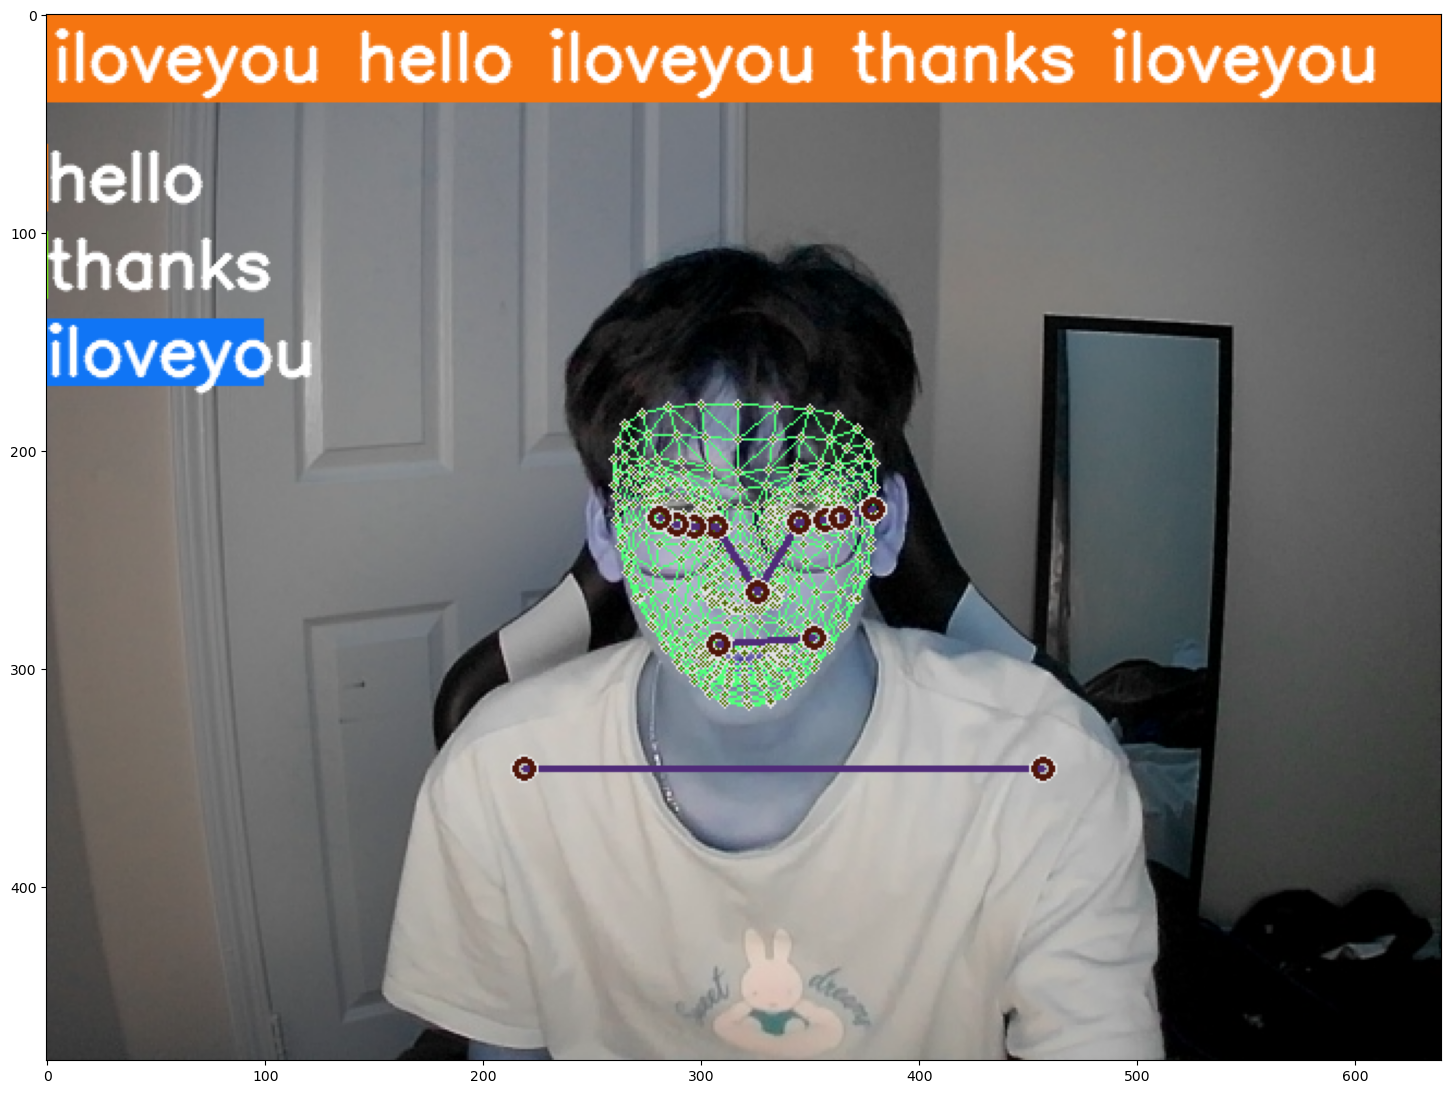

In [51]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

In [46]:
# 1. New detection variables
sequence = []
sentence = []
threshold = 0.8

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
#         sequence.insert(0,keypoints)
#         sequence = sequence[:30]
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            
        #3. Viz logic
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

1/1 [==============================] - 0s 20ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
hello
<class 'mediapipe.pyth

1/1 [==============================] - 0s 20ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
ilov

1/1 [==============================] - 0s 20ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
thanks
<class 'media

1/1 [==============================] - 0s 20ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
ilov

iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
iloveyou
<class 'mediapipe.python.solution_base.Solution

1/1 [==============================] - 0s 21ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
thanks
<class 'media

1/1 [==============================] - 0s 23ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
ilov

<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==================

1/1 [==============================] - 0s 21ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
ilov

1/1 [==============================] - 0s 20ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
thanks
<class 'media

1/1 [==============================] - 0s 21ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
ilov

iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
iloveyou
<class 'mediapipe.python.solution_base.Solution

In [52]:
cap.release()
cv2.destroyAllWindows()

In [53]:
res[np.argmax(res)] > threshold

True

In [56]:
model.predict(np.expand_dims(X_test[0], axis=0))

1/1 [==============================] - 0s 21ms/step


array([[7.8338765e-08, 9.9945790e-01, 5.4197334e-04]], dtype=float32)